In [1]:
from IPython.display import Video, clear_output

import time

import numpy as np
from PIL import Image

import pickle

import json

import os
import subprocess

In [2]:
Video("assets/englishbadapple24fps.mp4")

In [3]:
with open("data/scrabble_dictionary.txt", "r") as f:
    scrabble_dictionary = set(f.read().splitlines())
with open("data/lyrics.txt", "r") as f:
    lyrics_list = f.read().splitlines()

In [4]:
lyrics_text = " ".join(lyrics_list)
print(lyrics_text)

EVER ON AND ON EYE CONTINUE CIRCLING WITH NOTHING BUT MY HATE IN AH CAROUSEL OF AGONY TIL SLOWLY EYE FORGET AND MY HEART STARTS VANISHING AND SUDDENLY EYE SEE THAT EYE CANT BREAK FREE AIM SLIPPING THROUGH THE CRACKS OF AH DARK ETERNITY WITH NOTHING BUT MY PAIN AND THE PARALYZING AGONY TO TELL ME WHO EYE AM WHO EYE WAS UNCERTAINTY ENVELOPING MY MIND TIL EYE CANT BREAK FREE AND MAYBE ITS AH DREAM MAYBE NOTHING ELSE IS REAL BUT IT WOODEN MEAN AH THING IF EYE TOLD YOU HOW EYE FEEL SO AIM TIRED OF ALL THE PAIN ALL THE MISERY INSIDE AND EYE WISH THAT EYE COULD LIVE FEELING NOTHING BUT THE NIGHT YOU CAN TELL ME WHAT TO SAY YOU CAN TELL ME WHERE TO GO BUT EYE DOUBT THAT EYE WOULD CARE AND MY HEART WOULD NEVER KNOW IF EYE MAKE ANOTHER MOVE THURL BE NO MORE TURNING BACK BECAUSE EVERYTHING WILL CHANGE AND IT ALL WILL FADE TO BLACK WILL TOMORROW EVER COME WILL EYE MAKE IT THROUGH THE NIGHT WILL THERE EVER BE AH PLACE FOR THE BROKEN IN THE LIGHT AM EYE HURTING AM EYE SAD SHOULD EYE STAY OR SHOULD E

In [5]:
from package.board import INITIAL_LETTER_BANK

dict_removal_count = 0

for word in list(scrabble_dictionary):
    for alpha, count in INITIAL_LETTER_BANK().items():
        if word.count(alpha) > count + 2:
            scrabble_dictionary.remove(word)
            dict_removal_count += 1
            break

print("Removed a total of %d impossible words." % dict_removal_count)

Removed a total of 24 impossible words.


In [6]:
def lyrics_check(l, d):
    valid = True
    tile_shift = {}
    for line in l:
        line = line.strip()
        if line not in d:
            valid = False
            print("Invalid word found: %s" % line)
        elif len(line) > 7:
            subwords = sorted(list(filter(lambda s: len(s) <= 7 and len(line) - len(s) <= 7 and s in line, d)))
            closest_distance = 15
            closest_subword = ''
            for subword in subwords:
                index = line.index(subword)
                middle = len(line) // 2
                if index <= middle and index + len(subword) > middle:
                    closest_distance = 0
                elif index < middle and abs(middle - index) < abs(closest_distance):
                    closest_distance = middle - index
                    closest_subword = subword
                elif index + len(subword) >= middle and abs(middle - index) < abs(closest_distance):
                    closest_distance = middle - index
                    closest_subword = subword
            if closest_distance != 0:
                if closest_distance == 15:
                    print("%s cannot be possibly played at the exact center of the board.\n\tPotential subwords: %s\n\tNo valid subwords" % 
                          (line, ', '.join(subwords)))
                    valid = False
                else:
                    print("%s cannot be possibly played at the exact center of the board.\n\tPotential subwords: %s\n\tClosest subword: %s\n\tTile shift: %s" % 
                          (line, ', '.join(subwords), closest_subword, closest_distance))
                    tile_shift[line] = closest_distance
    return valid, tile_shift

is_valid, tile_shift = lyrics_check(lyrics_list, scrabble_dictionary)
print("Lyrics valid✓" if is_valid else "Lyric validation failed with Scrabble dictionary")
assert is_valid

PARALYZING cannot be possibly played at the exact center of the board.
	Potential subwords: ING, PAR, PARA, ZIN, ZING
	Closest subword: ZIN
	Tile shift: -1
PARALYZING cannot be possibly played at the exact center of the board.
	Potential subwords: ING, PAR, PARA, ZIN, ZING
	Closest subword: ZIN
	Tile shift: -1
Lyrics valid✓


In [7]:
import stable_whisper as whisper

In [8]:
timing_model = whisper.load_model("base")
print("Timing model loaded✓")

Timing model loaded✓


In [9]:
timings = timing_model.align("assets/englishbadapple.mp3", lyrics_text, language="en")
print("Timings generated✓")

Align: 100%|██████████| 219.12/219.12 [00:08<00:00, 27.14sec/s]
Adjustment: 100%|██████████| 209.4/209.4 [00:00<00:00, 23148.15sec/s]

Timings generated✓


In [10]:
timings.save_as_json("cache/timings.json")
print("Timings saved to disk")

Saved: C:\Users\kevin\Documents\Scrabble\cache\timings.json
Timings saved to disk


In [11]:
with open("cache/timings.json", "r", encoding='utf-8') as f:
    timing_results = json.load(f)
print("Timings loaded from disk")

Timings loaded from disk


In [12]:
for i in range(len(timing_results["segments"])):
    print(i, timing_results["segments"][i]["text"])

0  EVER ON AND ON EYE CONTINUE CIRCLING WITH NOTHING BUT MY HATE IN AH
1  CAROUSEL OF AGONY TIL SLOWLY EYE FORGET AND MY HEART STARTS VANISHING
2  AND SUDDENLY EYE SEE THAT EYE CANT BREAK FREE AIM SLIPPING
3  THROUGH THE CRACKS OF AH DARK ETERNITY WITH NOTHING BUT MY PAIN AND THE
4  PARALYZING AGONY TO TELL ME WHO EYE AM WHO EYE WAS UNCERTAINTY
5  ENVELOPING MY MIND TIL EYE CANT BREAK FREE AND MAYBE ITS AH DREAM MAYBE
6  NOTHING ELSE IS REAL BUT IT WOODEN MEAN AH THING IF EYE TOLD YOU
7  HOW EYE FEEL SO AIM TIRED OF ALL THE PAIN ALL THE MISERY INSIDE AND
8  EYE WISH THAT EYE COULD LIVE FEELING NOTHING BUT THE NIGHT YOU CAN
9  TELL ME WHAT TO SAY YOU CAN TELL ME WHERE TO GO BUT EYE DOUBT THAT
10  EYE WOULD CARE AND MY HEART WOULD NEVER KNOW IF EYE MAKE ANOTHER
11  MOVE THURL BE NO MORE TURNING BACK BECAUSE EVERYTHING WILL CHANGE
12  AND IT ALL WILL FADE TO BLACK WILL TOMORROW EVER COME WILL EYE MAKE
13  IT THROUGH THE NIGHT WILL THERE EVER BE AH PLACE FOR THE BROKEN IN
14  THE LIGHT AM 

In [13]:
assert timing_results["text"].strip() == lyrics_text
assert ' '.join([' '.join([word["word"].strip() for word in segment["words"]]) for segment in timing_results["segments"]]) == lyrics_text

In [14]:
class WordFrame:
    def __init__(self, word, start):
        self.word = word
        self.start = start
        self.shift = tile_shift.get(word, 0)

    def __str__(self):
        return "%d:%02d\t%s" % (self.start // 60, self.start % 60, self.word)

word_frames = []

# Amount at which time markers are advanced, for better visuals
time_advance = 0.1

def manual_fix_timing(previous_word, word):
    if previous_word["word"].strip() == "TO" and word["word"].strip() == "WHITE":
        modified_start = previous_word["start"] + 0.14
        print(word["word"].strip(), word["start"], "-->", modified_start)
        return modified_start
    return word["start"]

previous_word = {"word": "", "start": 0}

for segment in timing_results['segments']:
    for word in segment['words']:
        word_frames.append(WordFrame(word["word"].strip(), manual_fix_timing(previous_word, word) - time_advance))
        previous_word = word

print('\n'.join(map(str, word_frames)))

WHITE 126.18 --> 111.6
WHITE 195.18 --> 195.17999999999998
0:28	EVER
0:29	ON
0:29	AND
0:29	ON
0:30	EYE
0:30	CONTINUE
0:31	CIRCLING
0:32	WITH
0:32	NOTHING
0:32	BUT
0:33	MY
0:33	HATE
0:33	IN
0:34	AH
0:34	CAROUSEL
0:34	OF
0:35	AGONY
0:35	TIL
0:35	SLOWLY
0:36	EYE
0:36	FORGET
0:37	AND
0:37	MY
0:37	HEART
0:37	STARTS
0:38	VANISHING
0:39	AND
0:39	SUDDENLY
0:40	EYE
0:40	SEE
0:40	THAT
0:40	EYE
0:41	CANT
0:41	BREAK
0:42	FREE
0:42	AIM
0:42	SLIPPING
0:43	THROUGH
0:43	THE
0:43	CRACKS
0:44	OF
0:44	AH
0:44	DARK
0:44	ETERNITY
0:46	WITH
0:46	NOTHING
0:46	BUT
0:47	MY
0:47	PAIN
0:47	AND
0:47	THE
0:48	PARALYZING
0:49	AGONY
0:49	TO
0:49	TELL
0:50	ME
0:50	WHO
0:50	EYE
0:50	AM
0:51	WHO
0:51	EYE
0:51	WAS
0:51	UNCERTAINTY
0:53	ENVELOPING
0:53	MY
0:54	MIND
0:54	TIL
0:54	EYE
0:55	CANT
0:55	BREAK
0:55	FREE
0:56	AND
0:56	MAYBE
0:57	ITS
0:57	AH
0:57	DREAM
0:57	MAYBE
0:58	NOTHING
0:59	ELSE
0:59	IS
0:59	REAL
0:59	BUT
1:00	IT
1:00	WOODEN
1:00	MEAN
1:01	AH
1:01	THING
1:01	IF
1:01	EYE
1:02	TOLD
1:02	YOU
1:02	HOW
1:02	EYE

In [15]:
from package.trie import Trie

trie = Trie()
trie_reverse = Trie()

for word in scrabble_dictionary:
    trie.add_word(word)
    trie_reverse.add_word(word[::-1])

In [16]:
trie_words = set(trie.read())
if trie_words != scrabble_dictionary:
    print("Missing or extra words found in Trie:", end='\n\t')
    print('\t\n'.join(list(trie_words.difference(scrabble_dictionary))))
else:
    print("Trie build success✓")
assert trie_words == scrabble_dictionary

Trie build success✓


In [17]:
from package.gaddag import Gaddag

In [18]:
gaddag = Gaddag()

for word in scrabble_dictionary:
    gaddag.add_word(word)

In [19]:
gaddag_words = gaddag.read()
if gaddag_words != scrabble_dictionary:
    print("Missing or extra words found in GADDAG:", end='\n\t')
    print('\t\n'.join(list(gaddag_words.difference(scrabble_dictionary))))
else:
    print("GADDAG build success✓")
assert gaddag_words == scrabble_dictionary

GADDAG build success✓


In [20]:
TOTAL_FRAMES = 5258
FPS = 24

In [21]:
class Frame:
    def __init__(self, px):
        self.px = px

    def __eq__(self, other):
        return np.array_equal(self.px, other.px)

frame_info = []

for frame_number in range(1, TOTAL_FRAMES + 1):
    im = Image.open("assets/frames/frame%d.png" % frame_number)
    im = im.resize((15*3, 15*2))
    im = im.convert('L').point(lambda x: 255 if x > 125 else 0, mode='1')

    frames = {}

    for board_i in range(3):
        for board_j in range(2):
            px = im.crop((15*board_i, 15*board_j, 15*(board_i+1), 15*(board_j+1))).load()
            frames[(board_i, board_j)] = Frame(px)
            
    frame_info.append(frames)

In [22]:
# for f in range(len(frame_info)):
#     info = frame_info[f]
#     print("Frame %d" % (f+1))
#     for j in range(2):
#         for y in range(15):
#             for i in range(3):    
#                 pixels = info[(i, j)].px
#                 for x in range(15):
#                     print('#' if pixels[x,y] == 255 else ' ', end='')
#             print()
#     clear_output(wait=True)

In [23]:
from package.board import TwoByThreeBoards, Board, Direction, PossibilityMatrix, INITIAL_LETTER_BANK

class Move:
    def __init__(self, pos, word, direction, heuristic=0, score=0, placement_count=0):
        self.pos = pos
        self.word = word
        self.direction = direction
        self.heuristic = heuristic
        self.score = score
        self.placement_count = placement_count

    def __gt__(self, other):
        if self.heuristic == other.heuristic:
            return self.score > other.score
        return self.heuristic > other.heuristic

class BadAppleAlgorithm:
    def __init__(self, px, board, gaddag, letter_scores):
        self.px = px
        self.board = board
        self.gaddag = gaddag
        self.letter_scores = letter_scores
        self.skip_node_cache = {}
        self.racks = [[], []]
        self.current_player_index = 0
        self.temp_rack = []

    def has_value(self, pos, direction):
        x = pos[0] * direction.value[1]
        y = pos[1] * direction.value[0]
        while x < 15 and y < 15:
            if self.px[x,y] == 255 and self.board.is_empty(x, y):
                return True
            x += direction.value[0]
            y += direction.value[1]
        return False

    def get_heuristic(self, pos):
        x, y = pos
        if not self.board.is_empty(x, y):
            return 0
        if self.px[x,y] == 255:
            return 2
        return -1

    def find_best_prefix(self, pos, node, direction, rack, blanks, word="", heuristic=0, score=0, placement_count=0):
        x, y = pos

        # End of prefix
        if node.letter == '+':
            # Existing tiles continue
            if x >= 0 and y >= 0 and not self.board.is_empty(x, y):
                return None

            # No suffix
            if node.is_terminal:
                x1, y1 = x - direction.value[0], y - direction.value[1]
                x2, y2 = x + (len(word)+1) * direction.value[0], y + (len(word)+1) * direction.value[1]
                if (x1 < 0 or y1 < 0 or self.board.is_empty(x1, y1)) and (x2 >= 15 or y2 >= 15 or self.board.is_empty(x2, y2)):
                    return Move((x + direction.value[0], y + direction.value[1]), word, direction, heuristic, score, placement_count)
            
            # Get best suffix from children
            best_move = None
            for child in node.children.values():
                move = self.find_best_suffix((x + (len(word)+1) * direction.value[0], y + (len(word)+1) * direction.value[1]), child, direction, rack, blanks, word, heuristic, score, placement_count)
                if move is not None:
                    best_move = move if best_move is None else max(best_move, move)
            return best_move

        # Not possible
        if x < 0 or y < 0 or not self.board.can_place_letter(node.letter, pos, direction):
            return None

        updated_rack = rack.copy()

        # Increase placement if new tile
        if self.board.is_empty(x, y):
            if node.letter not in rack:
                if blanks == 0:
                    return None
                else:
                    blanks -= 1
            else:
                updated_rack.remove(node.letter)
            placement_count += 1
        if placement_count > 7:
            return None

        # Update prefix
        word = node.letter + word
        heuristic += self.get_heuristic(pos)
        if heuristic <= -7:
            return None
        score += self.letter_scores.get(node.letter, 0)
        
        # Get best prefix from children
        best_move = None
        for child in node.children.values():
            move = self.find_best_prefix((x - direction.value[0], y - direction.value[1]), child, direction, updated_rack, blanks, word, heuristic, score, placement_count)
            if move is not None:
                best_move = move if best_move is None else max(move, best_move)
        return best_move

    def find_best_suffix(self, pos, node, direction, rack, blanks, word, heuristic, score, placement_count):
        x, y = pos

        # Not possible
        if x >= 15 or y >= 15 or not self.board.can_place_letter(node.letter, pos, direction):
            return None

        updated_rack = rack.copy()

        # Increase placement if new tile
        if self.board.is_empty(x, y):
            if node.letter not in rack:
                if blanks == 0:
                    return None
                else:
                    blanks -= 1
            else:
                updated_rack.remove(node.letter)
            placement_count += 1
        if placement_count > 7:
            return None

        # Update suffix
        word += node.letter
        heuristic += self.get_heuristic(pos)
        if heuristic <= -7:
            return None
        score += self.letter_scores.get(node.letter, 0)
        
        x2, y2 = x + direction.value[0], y + direction.value[1]
            
        # End of suffix
        if node.is_terminal:
            if x2 < 15 and y2 < 15 and not self.board.is_empty(x2, y2):
                return None
            return Move((x - (len(word)-1) * direction.value[0], y - (len(word)-1) * direction.value[1]), word, direction, heuristic, score, placement_count)
        
        # Get best suffix from children
        moves = []
        for child in node.children.values():
            move = self.find_best_suffix((x2, y2), child, direction, updated_rack, blanks, word, heuristic, score, placement_count)
            if move is not None:
                moves.append(move)
        return None if len(moves) == 0 else max(moves)
    
    def get_best_move_in_direction(self, direction, rack):
        rack_without_blanks = rack.copy()
        blanks = rack.count('#')
        for b in range(blanks):
            rack_without_blanks.remove('#')

        best_move = None
        for a in self.board.adjacents:
            x, y = a
            for a_letter in self.board.possibilities[direction].get_possible(x, y):
                for head in self.gaddag.get(a_letter):
                    move = self.find_best_prefix((x, y), head, direction, rack_without_blanks, blanks)
                    if move is None:
                        continue
                    if move.placement_count > 0 and (best_move is None or move > best_move):
                        best_move = move
                        if best_move.heuristic >= 10:
                            return best_move
        return best_move

    def get_best_move(self, rack):
        directions = [Direction.DOWN, Direction.RIGHT]
        random.shuffle(directions)
        move1 = self.get_best_move_in_direction(directions[0], rack)
        if move1 is not None and move1.heuristic >= 10:
            move = move1
        else:
            move2 = self.get_best_move_in_direction(directions[1], rack)
            if move1 is None and move2 is None:
                return None, rack
            if move1 is None:
                return move2, rack
            if move2 is None:
                return move1, rack
            move = max(move1, move2)

        # Reintroduce blanks
        word_with_blanks = ""
        for letter in move.word:
            if letter not in rack and '#' in rack:
                # Lowercase signifies blank
                word_with_blanks += letter.lower()
                rack.remove('#')
            elif letter in rack:
                word_with_blanks += letter
                rack.remove(letter)
            else:
                word_with_blanks += letter
        move.word = word_with_blanks
        return move, rack

    def play(self, log=False):
        is_first_branch = True
        while True:
            self.racks[self.current_player_index] += self.board.draw_tiles(7 - len(self.racks[self.current_player_index]))
            print("Rack: %s" % ' '.join(self.racks[self.current_player_index]))
            move, self.racks[self.current_player_index] = self.get_best_move(self.racks[self.current_player_index].copy())
            if move is None or move.heuristic < 0:
                if log:
                    print("No good move")
                if is_first_branch:
                    self.board.clear()
                break
            if log:
                print(move.pos, move.direction, move.heuristic, move.word)
            self.board.place_word(move.word, move.pos, move.direction)
            is_first_branch = False
            self.current_player_index = 1 - self.current_player_index

In [24]:
letter_scores = {
    'A': 1,
    'E': 1,
    'I': 1,
    'O': 1,
    'U': 1,
    'L': 1,
    'N': 1,
    'S': 1,
    'T': 1,
    'R': 1,
    'D': 2,
    'G': 2,
    'B': 3,
    'C': 3,
    'M': 3,
    'P': 3,
    'F': 4,
    'H': 4,
    'V': 4,
    'W': 4,
    'Y': 4,
    'K': 5,
    'J': 8,
    'X': 8,
    'Q': 10,
    'Z': 10
}

In [25]:
def verify_board(board):
    bank1 = INITIAL_LETTER_BANK()
    bank2 = INITIAL_LETTER_BANK()
    success = True
    for x in range(15):
        word1 = ""
        word2 = ""
        for y in range(15):
            if board.is_empty(x, y):
                if word1 != "":
                    if len(word1) > 1 and word1 not in scrabble_dictionary:
                        print("Invalid word: (%d, %d) %s" % (x, y, word1))
                        success = False
                    word1 = ""
            else:
                letter = board.get_letter(x, y)
                actual_letter = '#' if board.is_blank(x, y) else letter
                if bank1[actual_letter] <= 0:
                    print("Insufficient letters: (%d, %d) %s" % (x, y, actual_letter))
                    success = False
                word1 += letter
                bank1[actual_letter] -= 1
            if board.is_empty(y, x):
                if word2 != "":
                    if len(word2) > 1 and word2 not in scrabble_dictionary:
                        print("Invalid word: (%d, %d) %s" % (y, x, word2))
                        success = False
                    word2 = ""
            else:
                letter = board.get_letter(y, x)
                actual_letter = '#' if board.is_blank(y, x) else letter
                if bank2[actual_letter] <= 0:
                    print("Insufficient letters: (%d, %d) %s" % (y, x, actual_letter))
                    success = False
                word2 += letter
                bank2[actual_letter] -= 1
    return success

In [26]:
import random
random.seed(0)

test_frame = 41
test_board_index = (2, 1)
scrabble_boards = TwoByThreeBoards(trie, trie_reverse, closeness_threshold=7)
scrabble_boards.clear()
pixels = frame_info[test_frame][test_board_index].px
alg = BadAppleAlgorithm(pixels, scrabble_boards.boards[test_board_index[0]][test_board_index[1]], gaddag, letter_scores)
for y in range(15):
    for x in range(15):
        if (x, y) in alg.board.adjacents:
            print('^', end='')
        else:
            print(alg.board.get_letter(x, y), end='')
    print()
for a in alg.board.anchors[Direction.RIGHT]:
    print(a, end=' ')
print()
for a in alg.board.anchors[Direction.DOWN]:
    print(a, end=' ')
print()
alg.board.possibilities[Direction.RIGHT].print()
alg.board.possibilities[Direction.DOWN].print()
for y in range(15):
    for x in range(15):
        print('#' if pixels[x,y] == 255 else ' ', end='')
    print()
alg.play(log=True)
for y in range(15):
    for x in range(15):
        print(alg.board.get_letter(x, y), end='')
    print()
print("Remaining letters:")
for alpha, count in alg.board.letter_bank.items():
    print("%s-%d" % (alpha, count), end=" ")
print()

---------------
---------------
---------------
---------------
---------------
---------------
---------------
-------^-------
---------------
---------------
---------------
---------------
---------------
---------------
---------------


*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	*	*	*	*	*	*	*	*	
*	*	*	*	*	*	*	

In [27]:
if verify_board(alg.board):
    print("Board is valid✓")

Insufficient letters: (13, 13) E
Insufficient letters: (14, 7) E
Insufficient letters: (14, 12) A
Insufficient letters: (12, 14) A


In [50]:
word_frames_iter = iter(word_frames)
next_root_word = next(word_frames_iter)
current_word = None

results = np.empty((15*3,0))

def coord_to_text(i, j):
    vert = ["TOP", "BOTTOM"]
    hori = ["LEFT", "MIDDLE", "RIGHT"]
    return vert[j] + " " + hori[i]

start_time = time.time()
        
for frame_number in range(1, TOTAL_FRAMES + 1):
    frame_time = frame_number / FPS
    
    if next_root_word != None and frame_time >= next_root_word.start:
        next_next_root_word = next(word_frames_iter, None)
        current_word = next_root_word
        next_root_word = next_next_root_word
            
    for i in range(3):
        for j in range(2):
            frame = frame_info[frame_number-1][(i, j)]
            if frame_number > 1:
                print("Generating Frame (%d %s)...\nAverage time: %fs" % (frame_number, coord_to_text(i, j), (time.time() - start_time)/((frame_number-1)*6+i*2+j)))
                prev_frame = frame_info[frame_number-2][(i, j)]
                if frame == prev_frame:
                    continue
            board = scrabble_boards.boards[i][j]
            board.clear()
            board.set_points_of_interest(frame.points_of_interest)
            alg = BadAppleAlgorithm(frame.px, board)
            if current_word is not None:
                board.place_root_word(current_word.word, current_word.shift)
                for letter in current.word:
                    board.letter_bank[letter] -= 1
                alg.play()
            clear_output(wait=True)
                            
    results = np.concatenate((results, scrabble_boards.array()), axis=1)

print("All %s frames generated✓" % TOTAL_FRAMES)

TypeError: BadAppleAlgorithm.__init__() missing 2 required positional arguments: 'gaddag' and 'letter_scores'

In [27]:
np.save("cache/results.npy", results, allow_pickle=True)
print("Results saved to disk")

Results saved to disk


In [33]:
results = np.load("cache/results.npy", allow_pickle=True)
print(results.shape)
print("Results loaded from disk")

(45, 157740)
Results loaded from disk


In [34]:
for i in range(1, TOTAL_FRAMES+1):
    for y in range(15*2):
        for x in range(15*3):
            print(results[x,i*15*2+y].decode("utf-8"), end='')
        print()
    print("Frame %d" % i)
    time.sleep(0.1)
    clear_output(wait=True)

---------P--I-----------JA----P---------V----
------INDOLENT-------INTERMIX-A---I--INDOCILE
---------M-ED-------COOEE--N--T---N----EX-N--
---------P--EA-------------TE-OBO-D----P--DE-
-------FRAWZEYS-------FRAWZEYSO---E--FRAWZEYS
-------U-D--D------INDUED--RE-THEAVE-U-R--EE-
-------S-O------------S--

KeyboardInterrupt: 

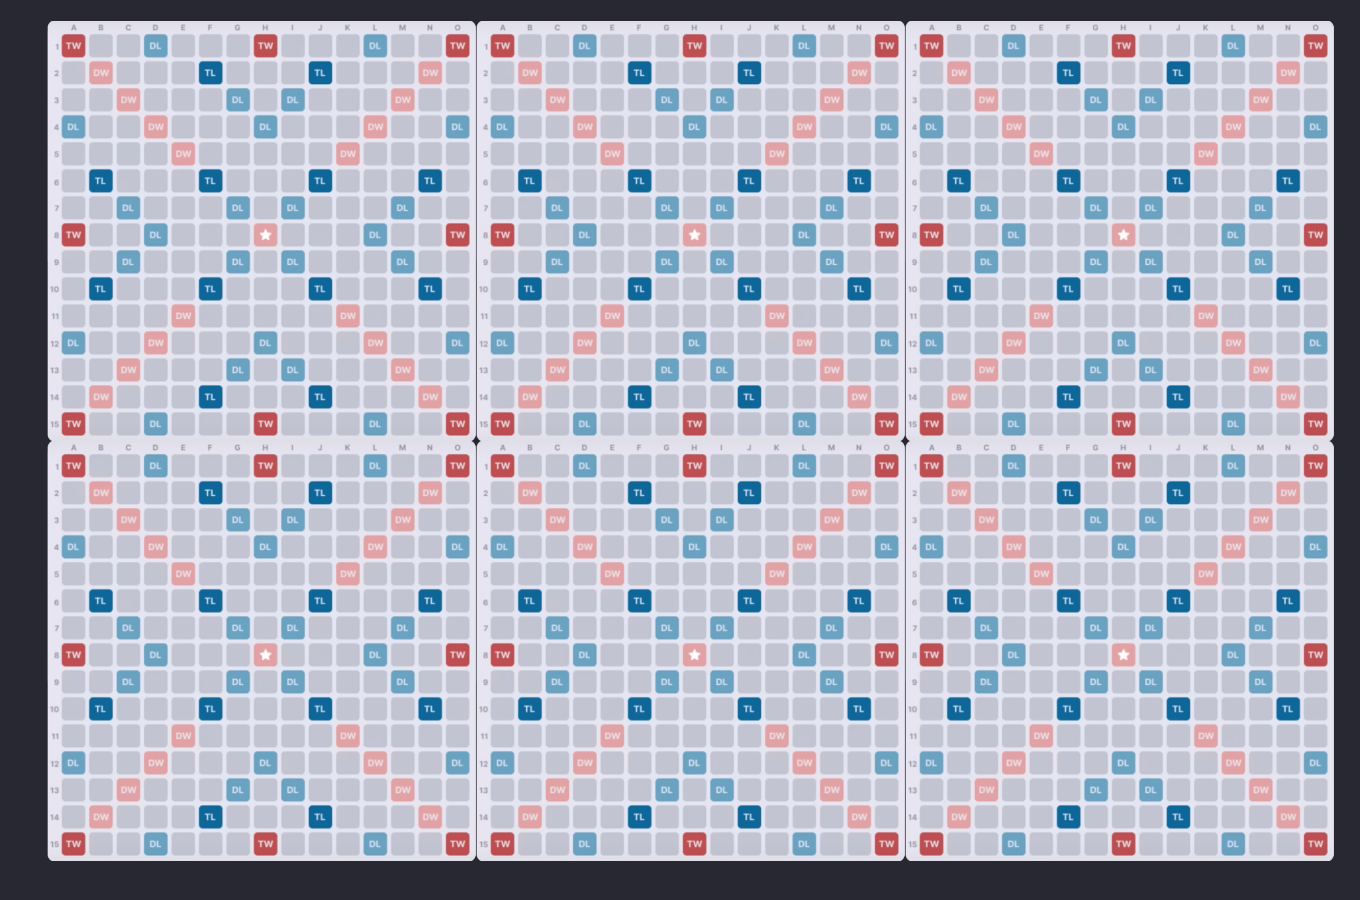

In [28]:
from PIL import ImageDraw, ImageFont

import matplotlib
# matplotlib.use("qt5agg")
import matplotlib.pyplot as plt
import matplotlib.animation as anim

%matplotlib widget

matplotlib.rcParams['animation.embed_limit'] = 2**128
plt.rcParams["figure.figsize"] = (13.6, 9)

class Canvas:
    board_offsets = [
        ((92, 696),
        (736, 696),
        (1380, 696),),
        ((92, 65),
        (736, 65),
        (1380, 65))
    ]

    tile_offset_x = 40.8
    tile_offset_y = 40.2

    def __init__(self, data):
        self.data = data
        
        board_img = Image.open('assets/Board.png')
        tile_img = Image.open('assets/Tile.png').resize((41, 41))
        
        self.fig, self.axarr = plt.subplots(2, 3, figsize=(13.6, 9), dpi=100)
        # win = self.fig.canvas.window()
        # win.setFixedSize(win.size())
        
        self.fig.tight_layout()
        self.fig.patch.set_facecolor('#282833')
    
        letter_font = ImageFont.truetype('assets/InterstateBold.otf', 24)  
        score_font = ImageFont.truetype('assets/InterstateBold.otf', 12)
        
        self.tile_letter_imgs = {}
        self.tile_letter_imgs['#'] = tile_img
        for letter, score in letter_scores.items():
            img = tile_img.copy()
            draw = ImageDraw.Draw(img)
        
            letter_coords = (12, 7)
            if letter in 'I':
                letter_coords = (17, 7)
            if letter in 'WM':
                letter_coords = (10, 7)
        
            draw.text(letter_coords, letter, fill='black', font = letter_font)
        
            score_coords = (29, 27)
            if letter in 'AM':
                score_coords = (31, 27)
            elif letter in 'F':
                score_coords = (28, 27)
            elif letter in 'QZ':
                score_coords = (25, 27)
        
            draw.text(score_coords, str(score), fill='black', font = score_font, align='right')
            self.tile_letter_imgs[letter] = img
        
        for i in range(2):
            for j in range(3):
                self.axarr[i,j].imshow(board_img)
        
        plt.subplots_adjust(hspace=0, wspace=0)
        
        for i in range(2):
            for j in range(3):
                # Hide grid lines
                self.axarr[i,j].grid(False)
    
                # Hide axes ticks
                self.axarr[i,j].set_xticks([])
                self.axarr[i,j].set_yticks([])
    
                # Hide axes spines
                self.axarr[i,j].spines[['top','left','bottom','right']].set_visible(False)
    
                self.axarr[i,j].set_facecolor('#282833')

        self.tile_cache = {}

    def clear(self):
        for tile in self.tile_cache.values():
            tile.remove()
        self.tile_cache.clear()

    def draw_tile(self, letter, i, j, x, y):
        if (i, j, x, y) in self.tile_cache:
            self.tile_cache[(i, j, x, y)].remove()
            self.tile_cache.pop((i, j, x, y))
        if letter == '-':
            return
        x0 = self.board_offsets[i][j][0] + x*self.tile_offset_x
        y0 = self.board_offsets[i][j][1] + y*self.tile_offset_y
        self.tile_cache[(i, j, x, y)] = self.fig.figimage(self.tile_letter_imgs[letter], x0, y0, zorder=1, alpha=1)

    def draw_board(self, index):
        for i in range(2):
            for j in range(3):
                board_index = j+2 + i
                for x in range(15):
                    for y in range(15):
                        letter = self.data[j*15+x,index*15*2+i*15+y].decode("utf-8")
                        if index > 0 and letter == self.data[j*15+x,(index-1)*15*2+i*15+y].decode("utf-8"):
                            continue
                        self.draw_tile(letter, i, j, x, y)

canvas = Canvas(results)

In [29]:
def update(i):
    print("Rendering frame %d..." % i, end='\r')
    canvas.draw_board(i)

canvas.clear()
render = anim.FuncAnimation(canvas.fig, update, frames=TOTAL_FRAMES, repeat=False)
writervideo = anim.FFMpegWriter(fps=FPS) 
render.save('cache/animation.mp4', writer=writervideo, dpi=150) 

Rendering frame 5257...

In [30]:
Video("cache/animation.mp4", width=1024, height=576)

In [31]:
result = subprocess.run("ffmpeg -y -i cache/animation.mp4 -i assets/englishbadapple.mp3 -c copy -map 0:v:0 -map 1:a:0 outputs/final.mp4".split(' '), 
                        stdout=subprocess.PIPE, stderr=subprocess.PIPE)
if result.stdout != b'':
    print(result.stdout.decode('utf-8'))
if result.stderr != b'':
    print(result.stderr.decode('utf-8'))

ffmpeg version 7.0.2-full_build-www.gyan.dev Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 13.2.0 (Rev5, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-libsnappy --enable-zlib --enable-librist --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-sdl2 --enable-libaribb24 --enable-libaribcaption --enable-libdav1d --enable-libdavs2 --enable-libuavs3d --enable-libxevd --enable-libzvbi --enable-librav1e --enable-libsvtav1 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs2 --enable-libxeve --enable-libxvid --enable-libaom --enable-libjxl --enable-libopenjpeg --enable-libvpx --enable-mediafoundation --enable-libass --enable-frei0r --enable-libfreetype --enable-libfribidi --enable-libharfbuzz --enable-li

In [32]:
Video("outputs/final.mp4", width=1024, height=576)